<ol>
    <li>We are car rental and have 2 car parks.</li>
    <li>Each park have maximum 20 cars.</li>
    <li>We gain 10 dolar each rent and loss 2 dolar each location change at night.<b> Rewards </b></li>
    <li>We can change the maxiumum 5 car location at the night.<b> Action </b></li>
    <li>Lambda of rental request is 3 and 4, rental returns are 3 and 2.</li>
    <li>Discount rate 0.9.</li>
</ol>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()

rent_income = 10
move_cost = 2
discount = 0.9
MAX_CAR_GARAGE = 20
MAX_CAR_MOVE = 5
MAX_CAR_USE = MAX_CAR_GARAGE+MAX_CAR_MOVE
lambda_rent = [3,4]
lambda_return = [3,2]
accurate = 1e-8

In [22]:
Tp = np.zeros(2*21*21).reshape(2,21,21)
R = np.zeros(2*21).reshape(2,21)
V = np.zeros(21*21).reshape(21,21)
Action = np.zeros(21*21).reshape(21,21)


In [23]:
def possion_prob(lam,n):
    return np.exp(-lam) * (lam**n) / np.math.factorial(n)

In [24]:
def trans_prob(s, garage):
    for r in range(0,MAX_CAR_GARAGE+1):
        p_rent = possion_prob(lambda_rent[garage], r)
        if p_rent<accurate:
            return
        rent = min(s, r)
        R[garage, s] += p_rent * rent_income * rent
        for ret in range(0,MAX_CAR_GARAGE+1):
           p_ret = possion_prob(lambda_return[garage], ret)
           if p_ret<accurate:
               continue
           s_next = min(s-rent+ret, MAX_CAR_GARAGE)
           Tp[garage, s, s_next] += p_rent * p_ret

for i in range(0,MAX_CAR_GARAGE+1):
        trans_prob(i, 0)
        trans_prob(i, 1)  

In [25]:
def policy_evalue():
    delta = 0
    for i in range(0,MAX_CAR_GARAGE+1):
        for j in range(0,MAX_CAR_GARAGE+1):
            v = V[i,j]
            temp_v = 0
            for m in range(0,MAX_CAR_GARAGE+1):
                for n in range(0,MAX_CAR_GARAGE+1):
                    temp_v += Tp[0,i,m]*Tp[1,j,n]*(R[0,i] + R[1,j] + discount*V[m,n])
            V[i,j] = temp_v
            delta = max(delta, np.abs(v-V[i,j]))
    return delta
    
def policy_evalue2():
    delta = 0
    for i in range(0,MAX_CAR_GARAGE+1):
        for j in range(0,MAX_CAR_GARAGE+1):
            v = V[i,j]
            a = Action[i,j]
            V[i,j] = value_calculate_matrix(i,j,a)
            delta = max(delta, np.abs(v-V[i,j]))
    return delta

In [26]:
def value_calculate(i,j,a):
    """
    a: move from garage_0 to garage_1; a \in [-5,5]
    """
    if a>i:
        a = i
    elif a<0 and -a>j:
        a = -j
    ii = int(i - a)
    jj = int(j + a)
    ii = min(ii, MAX_CAR_GARAGE)
    jj = min(jj, MAX_CAR_GARAGE) # after move_action, update (i,j) to (ii,jj)
    temp_v = -np.abs(a) * move_cost
    for m in range(0,MAX_CAR_GARAGE+1):
        for n in range(0,MAX_CAR_GARAGE+1):
            temp_v += Tp[0,ii,m]*Tp[1,jj,n]*(R[0,ii] + R[1,jj] + discount*V[m,n])
    return temp_v

def value_calculate_matrix(i,j,a):
    if a>i:
        a = i
    elif a<0 and -a>j:
        a = -j
    ii = int(i - a)
    jj = int(j + a)
    ii = min(ii, MAX_CAR_GARAGE)
    jj = min(jj, MAX_CAR_GARAGE) # after move_action, update (i,j) to (ii,jj)
    Tp_matrix = np.outer(Tp[0,jj], Tp[1,ii])
    V_matrix = discount*np.mat(V)
    V_matrix = np.add(V_matrix, np.transpose(R[0,ii]))
    V_matrix = np.add(V_matrix, R[1,jj])
    V_matrix -= np.abs(a) * move_cost
    V_matrix = np.multiply(Tp_matrix, V_matrix)
    return np.sum(V_matrix)

In [27]:
def action_greedy(i,j):
    best_action = 0
    best_value = 0
    for a in range(-MAX_CAR_MOVE, MAX_CAR_MOVE+1):
        if a>i:
            continue
        elif a<0 and -a>j:
            continue
        val = value_calculate(i,j,a)
        if val>best_value+0.1:
            best_value = val
            best_action = a
    return best_action

def policy_improve():
    stable_flag = True
    for i in range(0,MAX_CAR_GARAGE+1):
        for j in range(0,MAX_CAR_GARAGE+1):
            act_best = action_greedy(i,j)
            if act_best != Action[i,j]:
                Action[i,j] = act_best
                stable_flag = False
    return stable_flag

In [28]:
def plot_value1():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Income')
    aZ = []
    aX = []
    aY = []
    for i in range (MAX_CAR_GARAGE+1):
        for j in range (MAX_CAR_GARAGE+1):
            aX.append(i)
            aY.append(j)
            aZ.append(V[i, j])
    ax.set_ylabel('# of cars at location 1')
    ax.set_xlabel('# of cars at location 2')
    ax.scatter(aX, aY, aZ)  
  
def plot_value2():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(0,MAX_CAR_GARAGE+1), range(0,MAX_CAR_GARAGE+1))
    ax.scatter(X, Y, V) 
    

In [29]:
def print_policy(p,i=''):
    plt.figure()
    ticks = [0]+['']*(MAX_CAR_GARAGE-1)+[MAX_CAR_GARAGE]
    ax = sns.heatmap(p.astype(int),square=True,xticklabels=ticks,yticklabels=ticks)
    ax.set_title('Policy '+str(i))
    ax.set_ylabel('# of cars at location 1')
    ax.set_xlabel('# of cars at location 2')
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(MAX_CAR_MOVE*2+1)-MAX_CAR_MOVE)
    cbar.set_ticklabels(np.arange(MAX_CAR_MOVE*2+1)-MAX_CAR_MOVE)    
    

Evaluate Policies...
Evaluate Finished!
Improve Policies...
Evaluate Policies...
Evaluate Finished!
Improve Policies...
Evaluate Policies...
Evaluate Finished!
Improve Policies...
Evaluate Policies...
Evaluate Finished!
Improve Policies...


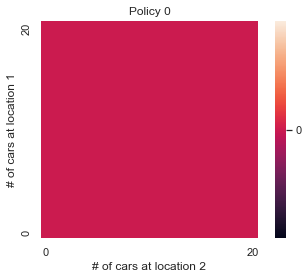

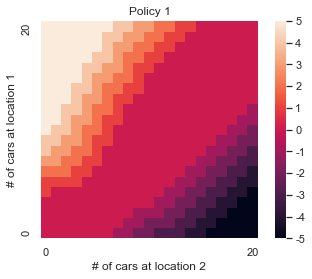

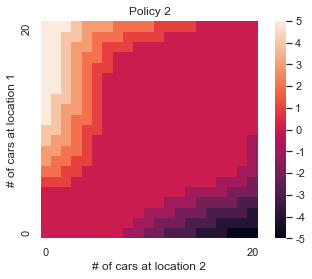

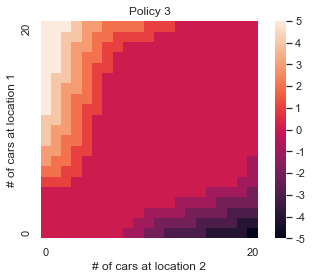

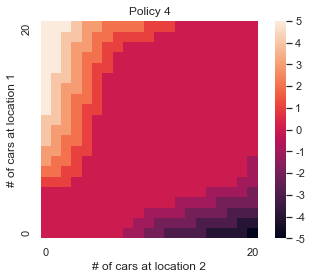

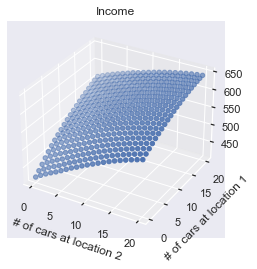

In [30]:
stable = False
policies = [Action.copy()]
while not stable:
    print ("Evaluate Policies...")
    while 1:
        delta = policy_evalue2()
        if delta<0.1:
            print ("Evaluate Finished!")
            break
    print ("Improve Policies...")
    stable = policy_improve()
    policies.append(Action.copy())
    
for i,po in enumerate(policies):
    print_policy(po,i)    
    
plot_value1()
